In [1]:
import iris
import xarray as xr
import pandas as pd
import glob
import os
import datetime
import glob
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import cartopy.crs as ccrs

In [2]:
def crop_cube(cube1,cube2):
    lat_range = iris.Constraint(grid_latitude = lambda cell: cube2.coord("grid_latitude")[0].points <= cell <= cube2.coord("grid_latitude")[-1].points)
    lon_range = iris.Constraint(grid_longitude = lambda cell: cube2.coord("grid_longitude")[0].points <= cell <= cube2.coord("grid_longitude")[-1].points)
    cube1 = cube1.extract(lat_range)
    cube1 = cube1.extract(lon_range)
    return cube1

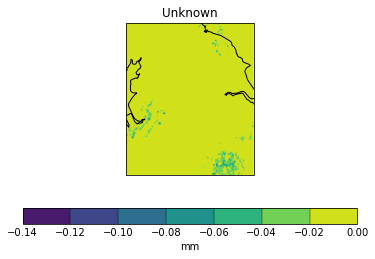

-0.0019553512063069907 0.008107290331342864


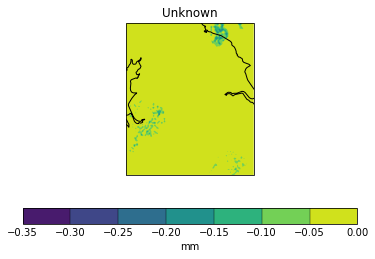

-0.004810089760638298 0.02120175613121715


In [3]:
new_cube=iris.load_cube("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_ens_pp_r30_t_60.nc")
old_cube_95=iris.load_cube("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_ens_perc_0.95_min_60_tot.nc")
old_cube_98=iris.load_cube("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_ens_perc_0.98_min_60_tot.nc")

old_cube_95=crop_cube(old_cube_95,new_cube)
old_cube_98=crop_cube(old_cube_98,new_cube)
new_cube_95=new_cube.extract(iris.Constraint(percentile=95))
new_cube_98=new_cube.extract(iris.Constraint(percentile=98))

diffs=old_cube_95-new_cube_95
contour = qplt.contourf(diffs)
plt.gca().coastlines()
plt.show()
print(diffs.data.mean(),diffs.data.std())

diffs=old_cube_98-new_cube_98
contour = qplt.contourf(diffs)
plt.gca().coastlines()
plt.show()
print(diffs.data.mean(),diffs.data.std())

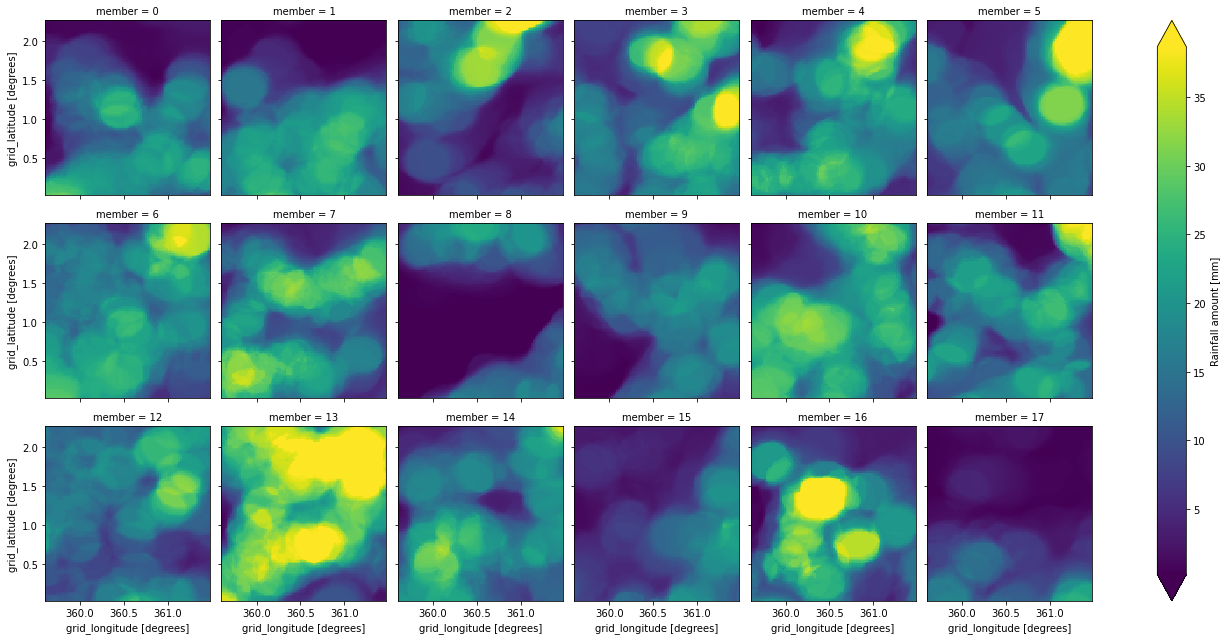

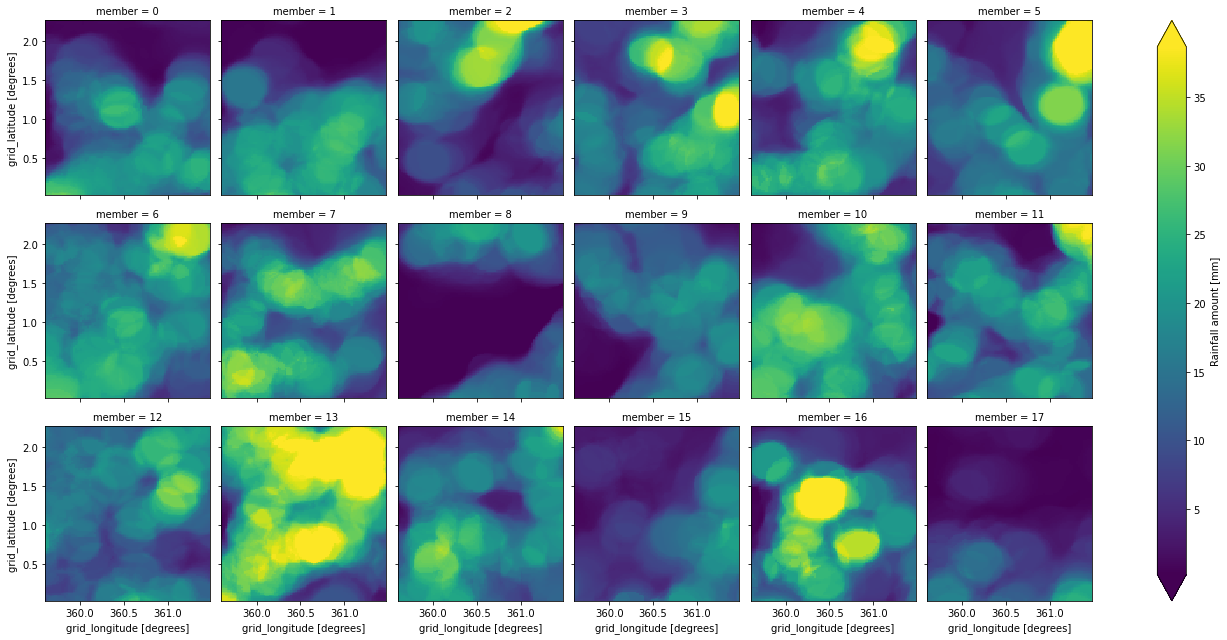

In [4]:
new_mem_ds=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_mem_pp_r30_t_60.nc")
new_mem_ds.rainfall_amount.sel(percentile=95).plot.pcolormesh(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

members=[]
for file in glob.glob("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_m??_perc_0.95_min_60_tot.nc"):
    file=xr.open_dataset(file)
    if len(file.coords) < 5:
        file=file.expand_dims(dim={"realization":1})
        file=file.assign_coords(realization=("realization", np.array([0])))
    
    members.append(file)
old_mem_ds=xr.concat(members,dim="realization")
old_mem_ds=old_mem_ds.rename({"realization":"member"})
old_mem_ds=old_mem_ds.assign_coords(member=("member", np.arange(0,18)))

old_mem_ds=old_mem_ds.sel(grid_latitude=slice(new_mem_ds.grid_latitude.min(),new_mem_ds.grid_latitude.max()),
                          grid_longitude=slice(new_mem_ds.grid_longitude.min(),new_mem_ds.grid_longitude.max()))
old_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

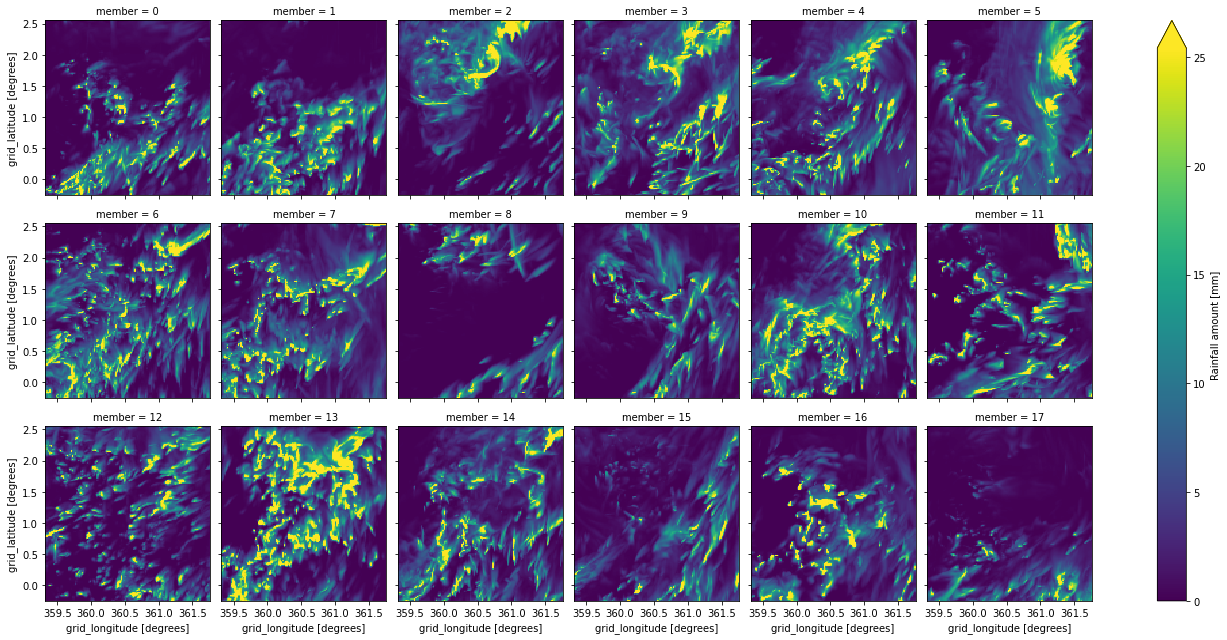

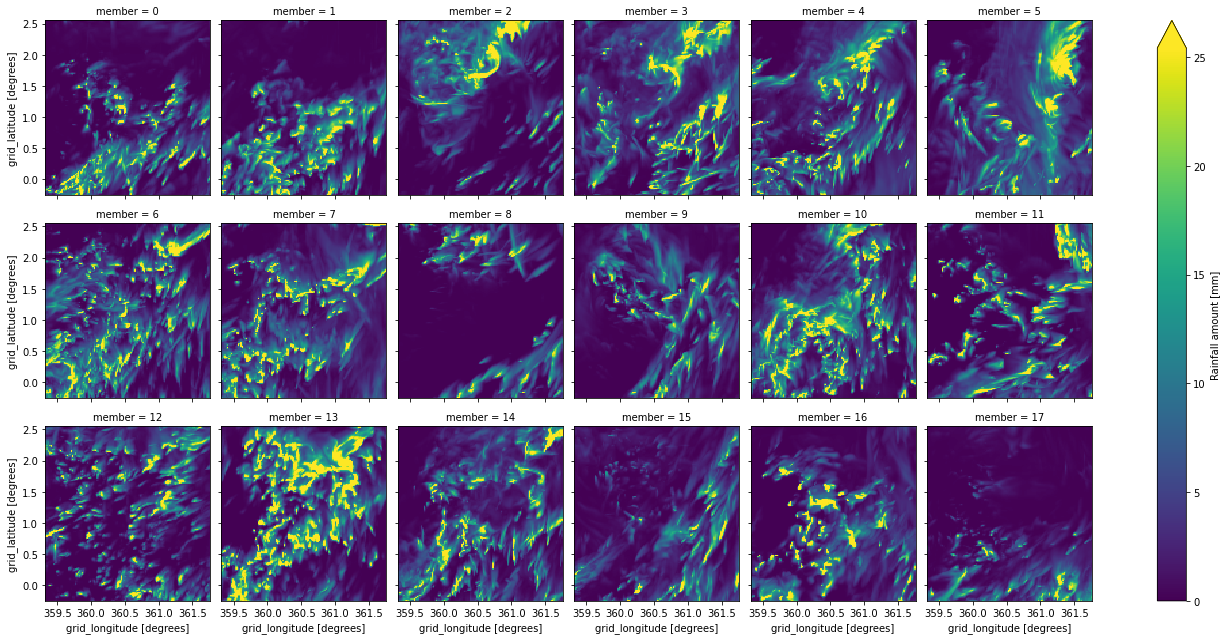

In [5]:
new_mem_ds=xr.open_dataset("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_max_rain_t_60.nc")
new_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

members=[]
for file in glob.glob("/gws/nopw/j04/icasp_swf/bmaybee/processed_forecasts/202208/20220815_08/20220816_m??_exact_min_60.nc"):
    file=xr.open_dataset(file)
    if len(file.coords) < 5:
        file=file.expand_dims(dim={"realization":1})
        file=file.assign_coords(realization=("realization", np.array([0])))
    
    members.append(file)
old_mem_ds=xr.concat(members,dim="realization")
old_mem_ds=old_mem_ds.rename({"realization":"member"})
old_mem_ds=old_mem_ds.assign_coords(member=("member", np.arange(0,18)))

old_mem_ds=old_mem_ds.sel(grid_latitude=slice(new_mem_ds.grid_latitude.min(),new_mem_ds.grid_latitude.max()),
                          grid_longitude=slice(new_mem_ds.grid_longitude.min(),new_mem_ds.grid_longitude.max()))
old_mem_ds.rainfall_amount.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6, robust=True)

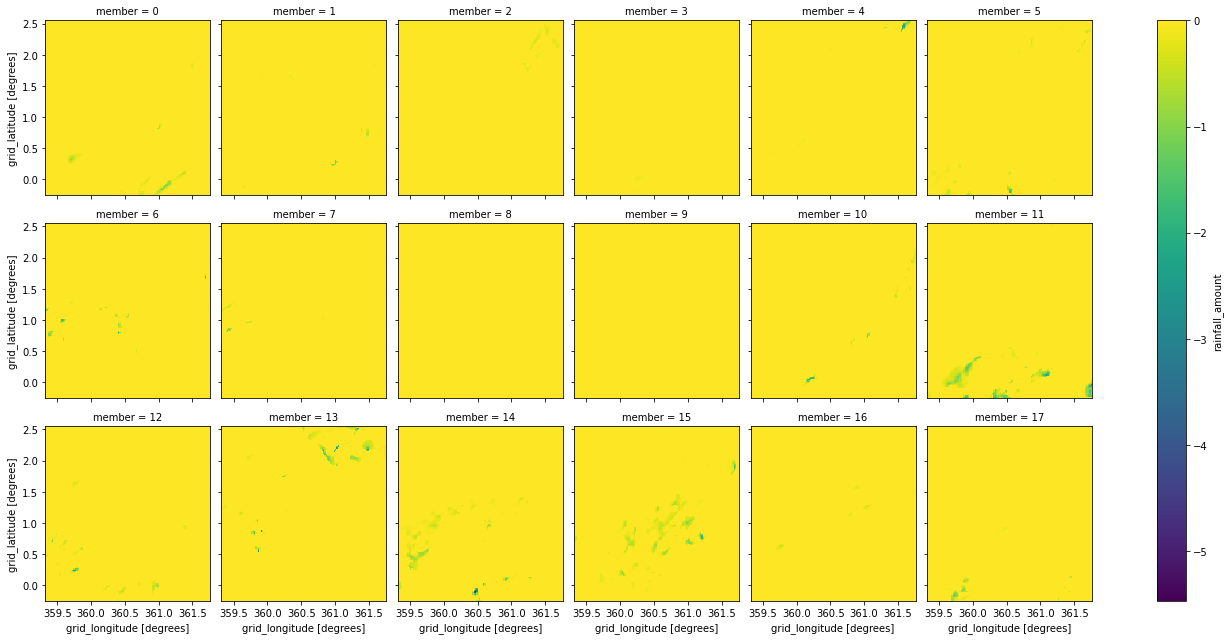

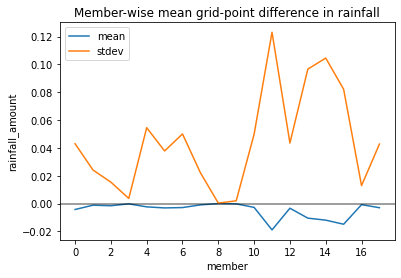

In [6]:
diffs=(old_mem_ds - new_mem_ds).rainfall_amount
diffs.plot(x="grid_longitude", y="grid_latitude", col="member", col_wrap=6)
plt.show()

diffs.mean(dim=["grid_longitude","grid_latitude"]).plot(label="mean")
diffs.std(dim=["grid_longitude","grid_latitude"]).plot(label="stdev")
plt.xticks(np.arange(0,18,2))
plt.axhline(0,alpha=0.5,color="black")
plt.title("Member-wise mean grid-point difference in rainfall")
plt.legend()

In [7]:
diffs.min()

<xarray.DataArray 'rainfall_amount' ()>
array(-5.46875, dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-08-16T11:57:30.000000256

In [8]:
fcst_day = datetime.datetime.strptime("20220816", "%Y%m%d")
fcst_stamp = datetime.datetime.strptime("2022081508", "%Y%m%d%H") 

(fcst_day - fcst_stamp).total_seconds()/3600

16.0

/opt/jaspy/lib/python3.10/site-packages/iris/coord_systems.py:528: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


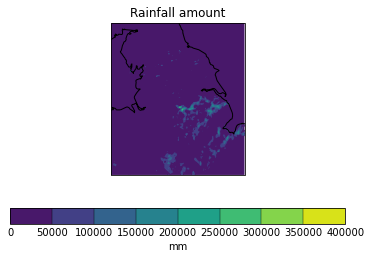

In [33]:
cube=iris.load_cube("/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_00/20220816_00_rad_exact_min_60.nc")
contour = qplt.contourf(cube[0])
plt.gca().coastlines()

In [34]:
cube

Rainfall Amount (mm),member,projection_y_coordinate,projection_x_coordinate
Shape,1,358,314
Dimension coordinates,,,
member,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Attributes,,,Conventions 'CF-1.7'least_significant_digit 2source 'fast_rainfall_postprocessing on MOGREPS_UK data'


In [27]:
def proc_rain(ffile):
    ccube=iris.load(ffile)[0]
    np.ma.masked_less(ccube.data,0.01)
    return ccube

def accums_mask(ffile):
    ccube=iris.load(ffile)[0]
    marray=np.ma.masked_less(ccube.data,2.5)
    return marray.mask

In [29]:
tfile="/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_exact_min_60_ind.nc"
rfile="/home/users/bmaybee/manual_forecast_scripts/fast_rainfall_processing_files/20220816_exact_min_60.nc"

ccube=iris.load_cube(tfile)
mask=accums_mask(rfile)
ccube.data=np.ma.masked_array(ccube.data,mask)
ccube.data=ccube.data/12.+3.

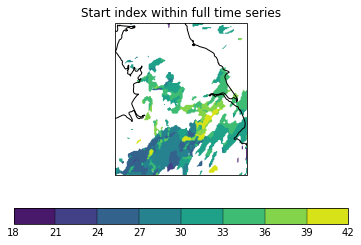

In [30]:
contour = qplt.contourf(ccube[0])
plt.gca().coastlines()